In [126]:
import os
import glob

import sqlite3
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from lsst.daf.persistence import Butler
from lsst.afw.table import BaseCatalog
import fakeInjectionPipeline as fip
import data_process_utils as dpu
import analysis_utils as au
from scipy.stats import norm
import scipy.stats as stats
import lsst.geom as geom
from scipy.stats import sigmaclip
from scipy.optimize import curve_fit
from scipy.stats import norm
from astropy.table import Table
import matplotlib.patches as mpatches
import lsst.geom as geom
from scipy.signal import convolve2d

import lsst.afw.image as afwImage
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
mpl.rcParams['font.size']=14

In [127]:
import imp
imp.reload(au)

<module 'analysis_utils' from '/global/cscratch1/sd/shl159/projects/fake_injection_summer_2022/dia_improvement/devel/analysis_utils.py'>

In [128]:
############################## efficiency ##############################

def cal_eff(fake_src_df):
    n_of_fake = len(fake_src_df)
    detected_fake = fake_src_df.loc[fake_src_df.matched_status.astype(bool)]
    eff = len(detected_fake) / n_of_fake
    err = np.sqrt( eff / n_of_fake )
    return eff, err, n_of_fake

def get_efficiency(fake_src_df, host_mag_list=None, fake_mag_list=None):
    eff_dict, err_dict, n_of_fake_dict = {}, {}, {}
    for host_mag in host_mag_list:
        efficiency_list = []
        err_list = []
        n_of_fake_list = []
        for fake_mag in fake_mag_list:
            fake_mag_str = str(fake_mag).replace('.', '')
            # fake_num, detected_fake = 0, 0
            fake_src = fake_src_df.loc[
                np.logical_and(
                    fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
            )].copy().reset_index(drop=True)
            eff, err, n_of_fake = cal_eff(fake_src)
            efficiency_list.append(eff)
            err_list.append(err)
            n_of_fake_list.append(n_of_fake)
        eff_dict[host_mag] = efficiency_list
        err_dict[host_mag] = err_list
        n_of_fake_dict[host_mag] = n_of_fake_list
    efficiency_list = []
    err_list = []
    n_of_fake_list = []    
    for fake_mag in fake_mag_list:
        fake_mag_str = str(fake_mag).replace('.', '')
        fake_src = fake_src_df.loc[fake_src_df.fake_mag == fake_mag_str]
        eff, err, n_of_fake = cal_eff(fake_src)
        efficiency_list.append(eff)
        err_list.append(err)
        n_of_fake_list.append(n_of_fake)
    eff_dict['all'] = efficiency_list
    err_dict['all'] = err_list
    n_of_fake_dict['all'] = n_of_fake_list 
    return eff_dict, err_dict, n_of_fake_dict

def sigmoid(x, a, b):
    y = 1 / (1 + np.exp( - a * (x - b) ) )
    return y

def fit_eff(fake_mag_list, eff_list, x_ls):
    popt, pcov = curve_fit(sigmoid, fake_mag_list, eff_list, bounds=((-20, 0),(0, 50)))
    m50 = - 1 / popt[0] * np.log(1 / 0.5 - 1) + popt[1]
    y_ls = []
    for x in x_ls:
        y = sigmoid(x, popt[0], popt[1])
        y_ls.append(y)
    return m50, y_ls
############################## flux residual ##############################
def get_residual(fake_src_df, fake_mag):
    res_dict = {}
    fake_mag_str = str(fake_mag).replace('.', '')
    fake_src = au.slice_df(fake_src_df, equal={'fake_mag': fake_mag_str})
    detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
    src_f = detected_fake['base_PsfFlux_instFlux']
    injected_f = detected_fake['injected_instFlux']
    src_inj = (src_f - injected_f) / injected_f
    return src_inj
def get_forced_residual(fake_src_df, fake_mag):
    res_dict = {}
    fake_mag_str = str(fake_mag).replace('.', '')
    fake_src = au.slice_df(fake_src_df, equal={'fake_mag': fake_mag_str})
    detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
    src_f = detected_fake['base_PsfFlux_instFlux_forced']
    injected_f = detected_fake['injected_instFlux']
    src_inj = (src_f - injected_f) / injected_f
    return src_inj

def remove_outlier(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    dist_from_mean = abs(arr - mean)
    max_deviations = 5
    not_outlier = dist_from_mean < max_deviations * std
    no_outliers = arr[not_outlier]
    return no_outliers
def add_label(violin, label, labels):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

def get_flux(config):
    flux_db_patch = f'./data/patch_0to6/diff/{config}/detection/detection.sqlite'
    conn = sqlite3.connect(flux_db_patch)
    full_query = (
        'SELECT base_PsfFlux_instFlux, injected_instFlux, base_PsfFlux_instFluxErr, '
        'fake_mag, matched_status FROM fake_src WHERE fake_mag = 20')
    diaSrc = pd.read_sql_query(full_query, conn)
    detected_fake = diaSrc.loc[diaSrc.matched_status.astype(bool)]
    df = (detected_fake.base_PsfFlux_instFlux - detected_fake.injected_instFlux) / detected_fake.base_PsfFlux_instFluxErr
    # df, _, _ = stats.sigmaclip(df.to_numpy())
    return df

def display_artifacts(row, d1, d2, figsize=(10,15), hspace=0.5, base_keep=True):

    calexp_width = row['calexp_fwhm']
    coadd_width = row['coadd_fwhm']
    diff_exp = afwImage.ExposureF(row['diffexp_path'])
    diff_diaSrc = BaseCatalog.readFits(row['diaSrc_path'])
    diff_diaSrc_astropy = diff_diaSrc.asAstropy()
    diff_diaSrc_astropy['snr'] = diff_diaSrc_astropy['base_PsfFlux_instFlux'] / diff_diaSrc_astropy['base_PsfFlux_instFluxErr']
    diff_diaSrc_astropy = diff_diaSrc_astropy[diff_diaSrc_astropy['snr']<60]
    if base_keep:
        diff_flag = dpu.keep_flag_astropy(diff_diaSrc_astropy, flag_list=base_flags)
    else:
        diff_flag = dpu.remove_flag_astropy(diff_diaSrc_astropy, flag_list=base_flags)
    
    
    fig, ax = plt.subplots(d1, d2, figsize=figsize)
    fig.subplots_adjust(hspace=hspace)
    ax_ls = ax.flat

    for i, diaSrc in enumerate(diff_flag):
        x = diaSrc['base_NaiveCentroid_x']
        y = diaSrc['base_NaiveCentroid_y']
        flux = diaSrc['base_PsfFlux_instFlux']
        fluxerr = diaSrc['base_PsfFlux_instFluxErr']

        diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
        ax_ls[i].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
        ax_ls[i].axis('off')
        
        if i == d1 * d2 - 1:
            break

def cross_cov(im1, im2, scale1, scale2, psf1, psf2):
    k1 = convolve2d(psf2, im1,  mode='same')
    k1 = k1 * scale1
    k2 = convolve2d(psf1, im2,  mode='same')
    k2 = k2 * scale2
    d = k2 - k1
    return d, k1, k2

"""
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']
"""

base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']

#### efficiency

In [4]:
conn = sqlite3.connect('./data/patch_0to6/diff/al_default/detection/detection.sqlite')
query = 'SELECT * FROM fake_src'
fake_src_df = pd.read_sql_query(query, conn)

conn = sqlite3.connect('./data/patch_0to6/diff_faint/al_default/detection/detection.sqlite')
query = (f"SELECT * FROM fake_src")
fake_src_df_faint = pd.read_sql_query(query, conn)

host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 20.5, 21, 21.5, 22, 22.5, 23, 23.5, 24]
fake_mag_list_faint = [23.0, 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24.0]

eff_dict, err_dict, n_of_fake_dict = get_efficiency(
    fake_src_df, host_mag_list=host_mag_list, fake_mag_list=fake_mag_list)
eff_dict_faint, err_dict_faint, n_of_fake_dict_faint = get_efficiency(
    fake_src_df_faint, host_mag_list=host_mag_list, fake_mag_list=fake_mag_list_faint)

fake_mag_merged = [20, 20.5, 21, 21.5, 22, 22.5,
                   23.0, 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24.0]
eff_merged, err_merged = {}, {}
for key in eff_dict.keys():
    eff_merged[key] = eff_dict[key][0:6] + eff_dict_faint[key]
    err_merged[key] = err_dict[key][0:6] + err_dict_faint[key]

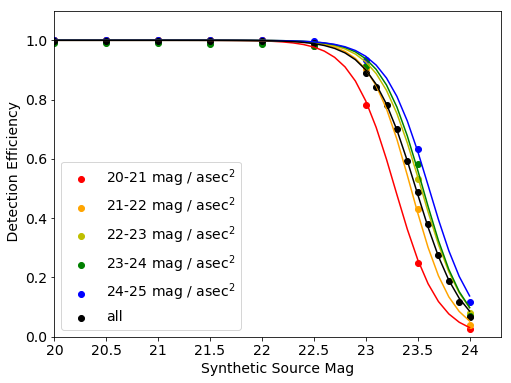

In [5]:
color_list=['r', 'orange', 'y', 'g', 'blue']
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
x_ls = np.arange(20, 24.09, 0.1)
for host_idx, host_mag in enumerate(host_mag_list):
    mag = host_mag.split('_')
    color = color_list[host_idx]
    _, y_ls = fit_eff(fake_mag_merged, eff_merged[host_mag], x_ls)
    ax.plot(x_ls, y_ls, color=color)
    # ax[0].errorbar(fake_mag_list, eff_dict[host_mag], yerr=err_dict[host_mag], marker='o', ls='--', color=color, label=f'{mag[0]}-{mag[1]} $mag / asec^2$')
    ax.scatter(fake_mag_list, eff_dict[host_mag],
               marker='o', color=color, label=f'{mag[0]}-{mag[1]} mag / asec$^2$')
_, y_ls = fit_eff(fake_mag_merged, eff_merged['all'], x_ls)
ax.scatter(fake_mag_merged, eff_merged['all'], marker='o', color='k', label='all')
ax.plot(x_ls, y_ls, color='k')

ax.set_xticks(fake_mag_list)
ax.set_xticklabels(fake_mag_list)
ax.set_xlim(20, 24.3)
ax.set_ylim((0., 1.1))
ax.set_xlabel('Synthetic Source Mag')
ax.set_ylabel(' Detection Efficiency')
#ax[0].set_title('eff vs. fake mag', size=15)
ax.legend()
# plt.savefig('./paper_plots/p_eff.pdf')

m50 is 23.483089249130998


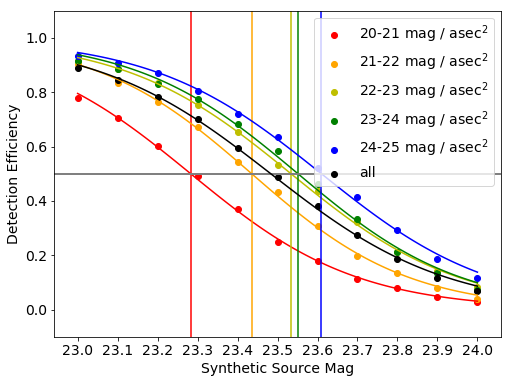

In [6]:
color_list=['r', 'orange', 'y', 'g', 'blue']
x_ls = np.arange(23, 24.009, 0.01)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for host_idx, host_mag in enumerate(host_mag_list):
    mag = host_mag.split('_')
    color = color_list[host_idx]
    m50, y_ls = fit_eff(fake_mag_merged, eff_merged[host_mag], x_ls)
    ax.axvline(x=m50, color=color)
    ax.plot(x_ls, y_ls, color=color)
    ax.scatter(fake_mag_list_faint, eff_dict_faint[host_mag], marker='o', color=color, label=f'{mag[0]}-{mag[1]} mag / asec$^2$')
    ax.axhline(y=0.5,color='gray')
m50, y_ls = fit_eff(fake_mag_merged, eff_merged['all'], x_ls)
print(f'm50 is {m50}')
ax.scatter(fake_mag_list_faint, eff_dict_faint['all'], marker='o', color='k', label='all')
ax.plot(x_ls, y_ls, color='k')
ax.set_xticks(fake_mag_list_faint)
ax.set_xticklabels(fake_mag_list_faint)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Synthetic Source Mag')
ax.set_ylabel('Detection Efficiency')
ax.legend()
#plt.savefig('./paper_plots/p_faint.pdf')


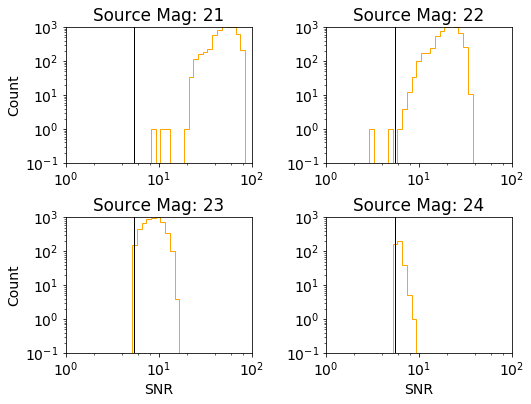

In [7]:
import matplotlib as mpl
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax_ls = ax.flat
for i, fake_mag in enumerate([21, 22, 23, 24]):
    fake_mag_str = str(fake_mag).replace('.', '')
    fake_src = fake_src_df.loc[
        fake_src_df.fake_mag == fake_mag_str
    ].copy().reset_index(drop=True)
    detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
    snr = detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr
    ax_ls[i].hist(snr, histtype='step', color='orange',
                  bins=np.logspace(np.log10(0.1),np.log10(1e4), 100))
    #ax_ls[i].loglog() 
    ax_ls[i].set_xscale('log')
    ax_ls[i].set_yscale('log')
    ax_ls[i].set_xlim(1e0, 1e2)
    ax_ls[i].set_ylim(1e-1, 1e3)
    # restore minor ticks
    # https://stackoverflow.com/questions/44078409/matplotlib-semi-log-plot-minor-tick-marks-are-gone-when-range-is-large
    locmaj = mpl.ticker.LogLocator(base=10,numticks=5) 
    ax_ls[i].xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10,subs=(0.2,0.4,0.6,0.8),numticks=5)
    ax_ls[i].xaxis.set_minor_locator(locmin)
    ax_ls[i].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax_ls[i].axvline(x=5.5, linewidth='1', color='black')
    ax_ls[i].set_title(f'Source Mag: {fake_mag}')
    if i%2==0:
        ax_ls[i].set_ylabel('Count')
    if i > 1:
        ax_ls[i].set_xlabel('SNR')
    # ax_ls[i].legend()
# plt.savefig('./paper_plots/p_snr_threshold.pdf')

In [8]:
def plot_snr_distribution(plot_type='log_lin', save_fig=False):
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax_ls = ax.flat
    for i, fake_mag in enumerate([21, 22, 23, 24]):
        fake_mag_str = str(fake_mag).replace('.', '')
        fake_src = fake_src_df.loc[
            fake_src_df.fake_mag == fake_mag_str
        ].copy().reset_index(drop=True)
        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        snr = detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr
        eff = len(detected_fake) / len(fake_src)

        ax_ls[i].set_xlim(1e0, 1e2)
        ax_ls[i].set_ylim(1e-1, 1e3+500)
        if plot_type == 'log_log':
            ax_ls[i].hist(snr, histtype='step', color='orange',
              bins=np.logspace(np.log10(0.1),np.log10(1e4), 100), label='SNR')
            ax_ls[i].set_xscale('log')
            ax_ls[i].set_yscale('log')
            restore_minor_ticks(ax_ls[i])
        elif plot_type == 'lin_lin':
            ax_ls[i].hist(snr, histtype='step', color='orange', bins=np.linspace(0, 1e2, 50), label='SNR')
        elif plot_type == 'log_lin':
            ax_ls[i].hist(snr, histtype='step', color='orange',
              bins=np.logspace(np.log10(0.1),np.log10(1e4), 100), label='SNR')
            ax_ls[i].set_xscale('log')
            restore_minor_ticks(ax_ls[i])
        elif plot_type == 'lin_log':
            ax_ls[i].hist(snr, histtype='step', color='orange', bins=np.linspace(0, 1e2, 50), label='SNR')
            ax_ls[i].set_yscale('log')
        else:
            print('plot type is not valid')
            break
        ax_ls[i].text(1.5,500, f'eff = {eff:.2f}', color='r')
        ax_ls[i].axvline(x=5.5, linewidth='1', linestyle='--', color='gray', label='5.5 threshold')
        ax_ls[i].set_title(f'Synthetic Source Mag: {fake_mag}', size=14)
        if i%2==0:
            ax_ls[i].set_ylabel('Count')
        if i > 1:
            ax_ls[i].set_xlabel('SNR')
        ax_ls[i].legend(fontsize=12)
    if save_fig:
        plt.savefig('./paper_plots/p_snr_threshold.pdf')
        
def restore_minor_ticks(ax):
    # restore minor ticks
    # https://stackoverflow.com/questions/44078409/matplotlib-semi-log-plot-minor-tick-marks-are-gone-when-range-is-large
    locmaj = mpl.ticker.LogLocator(base=10,numticks=5) 
    ax.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10,subs=(0.2,0.4,0.6,0.8),numticks=5)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

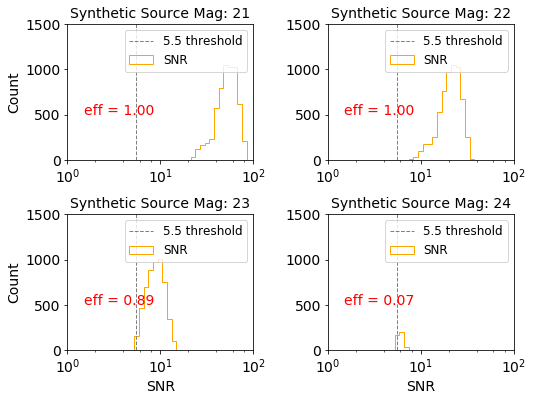

In [9]:
plot_snr_distribution(plot_type='log_lin', save_fig=True)

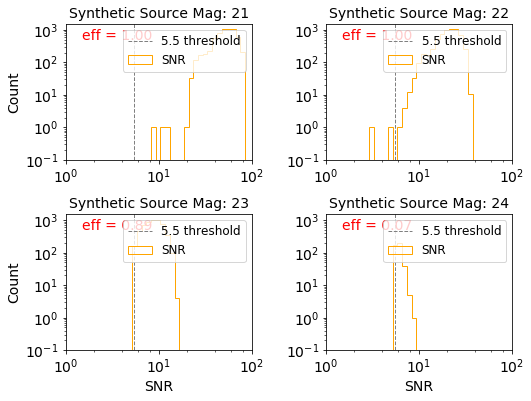

In [10]:
plot_snr_distribution(plot_type='log_log', save_fig=False)

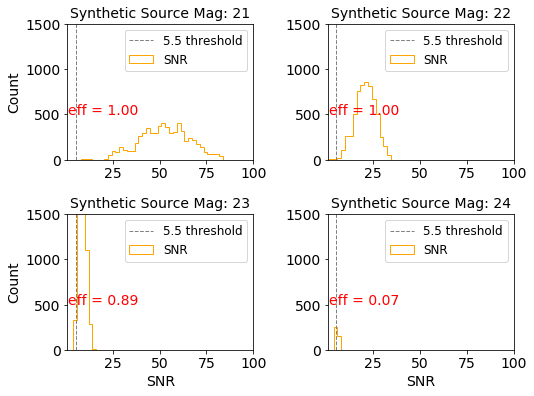

In [11]:
plot_snr_distribution(plot_type='lin_lin', save_fig=False)

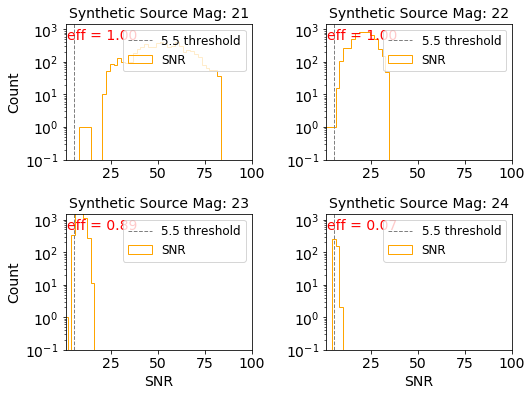

In [12]:
plot_snr_distribution(plot_type='lin_log', save_fig=False)

#### Flux Residual

b'20'


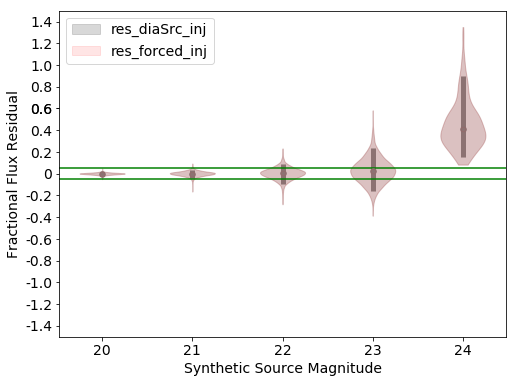

In [13]:
patch_list = ['00', '11', '22', '33', '44', '55', '66']
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]
injection_db_path = './data/table/gal_4639/injection_coord.sqlite'

calexp_info_dict, injection_coord_dict = fip.get_calexp_injection_dict(
    patch_list, host_mag_list, dbpath=injection_db_path
)
conn = sqlite3.connect('./data/patch_0to6/diff/al_default/detection/detection.sqlite')
query = (f"SELECT * FROM fake_src")
fake_src = pd.read_sql_query(query, conn)

forced_db = ('./data/patch_0to6/diff/al_default/forced/forced.sqlite')
conn = sqlite3.connect(forced_db)
forced_flux = pd.read_sql_query('SELECT * FROM forced', conn)

fake_src_det = fake_src.loc[fake_src.matched_status.astype(bool)].copy().reset_index(drop=True)
forced_flux_det = forced_flux.loc[forced_flux.matched_status.astype(bool)].copy().reset_index(drop=True)
print(forced_flux_det['fake_mag'][0])
forced_flux_det['host_mag'] = forced_flux_det['host_mag'].str.decode("utf-8")
forced_flux_det['fake_mag'] = forced_flux_det['fake_mag'].str.decode("utf-8")

patch_list = ['00', '11', '22', '33', '44', '55', '66']
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

res_list = []
forced_res_list = []
for fake_idx, fake_mag in enumerate(fake_mag_list):
    res = get_residual(fake_src_det, fake_mag=str(fake_mag))
    forced_res = get_forced_residual(forced_flux_det, fake_mag=str(fake_mag))
    
    res = remove_outlier(res.array)
    forced_res = remove_outlier(forced_res.array)
    res_list.append(list(res.to_numpy()))
    forced_res_list.append(list(forced_res.to_numpy()))
parts_diaSrc = ax.violinplot(res_list, showmedians=False, showextrema=False)
parts_forced = ax.violinplot(forced_res_list, showmedians=False, showextrema=False)

labels = []


for pc in parts_diaSrc['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('gray')
for pc in parts_forced['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('red')
    pc.set_alpha(0.1)
res_quartile1, res_medians, res_quartile3 = [], [], []
forced_res_quartile1, forced_res_medians, forced_res_quartile3 = [], [], []
for res in res_list:
    quartile1, medians, quartile3 = np.percentile(res, [5, 50, 95])
    res_quartile1.append(quartile1) 
    res_medians.append(medians) 
    res_quartile3.append(quartile3)

for res in forced_res_list:
    quartile1, medians, quartile3 = np.percentile(res, [5, 50, 95])
    forced_res_quartile1.append(quartile1) 
    forced_res_medians.append(medians) 
    forced_res_quartile3.append(quartile3)

add_label(parts_diaSrc, 'res_diaSrc_inj', labels)
add_label(parts_forced, 'res_forced_inj', labels)
# parts_forced['cmaxes'].set_color(['red', 'red', 'red', 'red'])
inds = np.arange(1, len(res_list) + 1)
ax.set_xticks([1,2,3,4,5])
ax.scatter(inds, res_medians, marker='o', color='gray', s=30, zorder=3)
ax.scatter(inds, forced_res_medians, marker='o', color='r', alpha=0.1, s=30, zorder=3)

ax.vlines(inds, res_quartile1, res_quartile3, color='gray', linestyle='-', lw=5)
ax.vlines(inds, forced_res_quartile1, forced_res_quartile3, color='r', alpha=0.1,
          linestyle='-', lw=5)
ax.axhline(y=0.05, color='green', label="5%")
ax.axhline(y=-0.05, color='green', label="-5%")
ax.set_xticklabels(['20', '21', '22', '23', '24'])
yticks = [-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.6,0.8,1.0,1.2,1.4]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
# ax.tick_params(axis='y', labelsize=10)
ax.set_ylabel('Fractional Flux Residual')
ax.set_xlabel('Synthetic Source Magnitude')
ax.set_ylim((-1.5, 1.5))
    
ldg = plt.legend(*zip(*labels[0:2]), loc=2)
plt.savefig('./paper_plots/p_res.pdf')

In [14]:
def add_patch(legend):
    from matplotlib.patches import Patch
    ax = legend.axes
    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor='g', edgecolor='g'))
    labels.append("+/- 5%")
    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())

#### Flux Pull

In [15]:
calexp_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1'
calexp_butler = Butler(calexp_repo)
psf_table = pd.read_csv('./data/table/gal_4639/psf_fwhm.csv')

columns = ['signal_21', 'noise_21', 'signal_22', 'noise_22', 'signal_23', 'noise_23', 'signal_24', 'noise_24']
snr_df =pd.DataFrame(columns=columns)

snr_dict = {}
for idx, row in psf_table.iterrows():
    visit, det, filt = row['visit'], row['detector'], row['filter']
    calexp_id = {'visit': visit, 'detector': det, 'filter': filt}
    calexp = calexp_butler.get('calexp', calexp_id)
    calexp_calib = calexp_butler.get(datasetType='calexp_photoCalib', dataId=calexp_id)
    variance = calexp.getVariance().array
    var, _ = au.estimate_sigmaclipped_mean_std(variance, threshold=5)
    noise = np.sqrt(var)
    row = []
    for mag in [21, 22, 23, 24]:
        signal = calexp_calib.magnitudeToInstFlux(mag)
        row.append(signal)
        row.append(noise)
    snr_df.loc[idx] = row
snr_df.to_csv('./mag_to_snr_use_var.csv', index=False)


In [16]:
snr_info = pd.read_csv('./mag_to_snr_use_var.csv')
test = pd.read_csv('./mag_to_snr.csv')

In [17]:
# distribution_theory

In [18]:
len(distribution_theory), len(distribution_cut)

NameError: name 'distribution_theory' is not defined

In [ ]:
norm_x = np.arange(-5, 5, 0.1)
norm_y = norm.pdf(norm_x)
norm_cdf = norm(loc=0, scale=1).cdf
threshold = 5.5

flux_db_patch = (
        f'./data'
        f'/patch_0to6/diff/al_default/detection/detection.sqlite'
)
conn = sqlite3.connect(flux_db_patch)

full_query = 'SELECT * FROM fake_src'
fake_src_full = pd.read_sql_query(full_query, conn)

fig, ax = plt.subplots(2, 2, figsize=(8, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
ax_ls = ax.flat
bins = np.linspace(-5, 5, 200)
for i, fake_mag in enumerate([21, 22, 23, 24]):
    
    fake_mag_str = str(fake_mag).replace('.', '')
    fake_src = fake_src_full.loc[
        fake_src_full.fake_mag == fake_mag_str
    ].copy().reset_index(drop=True)
    detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
    dflux = (detected_fake.base_PsfFlux_instFlux - detected_fake.injected_instFlux) / detected_fake.base_PsfFlux_instFluxErr
    
    
    mean_theory = snr_info[f'signal_{fake_mag}'].mean()
    std_theory = snr_info[f'noise_{fake_mag}'].mean()
    distribution_theory = np.random.normal(mean_theory, std_theory, 10000)
    distribution_cut = distribution_theory[distribution_theory > (threshold * std_theory)]
    normalized_cut = (distribution_cut - mean_theory) / std_theory
    
    ax_ls[i].hist(normalized_cut, histtype='step', color='blue', density=True, bins=bins, label='theory')
    ax_ls[i].hist(dflux, histtype='step', color='orange', density=True, bins=bins, label='data')
    ax_ls[i].plot(norm_x, norm_y, color='k', label='N(0,1)')
    ax_ls[i].set_xlim(-5, 5)
    ax_ls[i].set_ylim(0., 1)
    ax_ls[i].set_title(f'Source Mag: {fake_mag}')

    if i > 1:
        ax_ls[i].set_xlabel('$\Delta f / \sigma$')
    if i%2==0:
        ax_ls[i].set_ylabel('Density')
    ax_ls[i].legend()
#plt.suptitle('Flux Pull Distribution')
# plt.savefig('./paper_plots/p_pull.pdf')

In [ ]:
norm_x = np.arange(-5, 5, 0.1)
norm_y = norm.pdf(norm_x)
norm_cdf = norm(loc=0, scale=1).cdf

flux_db_patch = (
        f'./data'
        f'/patch_0to6/diff/al_default/detection/detection.sqlite'
)
conn = sqlite3.connect(flux_db_patch)

full_query = 'SELECT * FROM fake_src'
fake_src_full = pd.read_sql_query(full_query, conn)

fig, ax = plt.subplots(2, 2, figsize=(8, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
ax_ls = ax.flat
bins = np.linspace(-5, 5, 200)
for i, fake_mag in enumerate([21, 22, 23, 24]):
    fake_mag_str = str(fake_mag).replace('.', '')
    fake_src = fake_src_full.loc[
        fake_src_full.fake_mag == fake_mag_str
    ].copy().reset_index(drop=True)
    detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
    dflux = (detected_fake.base_PsfFlux_instFlux - detected_fake.injected_instFlux) / detected_fake.base_PsfFlux_instFluxErr
    ax_ls[i].hist(dflux, histtype='step', color='orange', density=True, bins=bins, label='data')
    ax_ls[i].plot(norm_x, norm_y, color='k', label='N(0,1)')
    ax_ls[i].set_xlim(-5, 5)
    ax_ls[i].set_ylim(0., 1)
    ax_ls[i].set_title(f'Source Mag: {fake_mag}')

    if i > 1:
        ax_ls[i].set_xlabel('$\Delta f / \sigma$')
    if i%2==0:
        ax_ls[i].set_ylabel('Density')
    ax_ls[i].legend()
#plt.suptitle('Flux Pull Distribution')
plt.savefig('./paper_plots/p_pull.pdf')

#### Config

In [ ]:
def plot_config(config, save_path):
    norm_x = np.arange(-5, 5, 0.1)
    norm_y = norm.pdf(norm_x)
    norm_cdf = norm(loc=0, scale=1).cdf
    flux = get_flux(config)
    
    bins = np.linspace(-5, 5, 200)
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    fig.subplots_adjust(hspace=0.7, wspace=0.7)
    
    c_mean = np.nanmean(df)
    c_std = np.nanstd(df)
    ax.hist(flux ,density=True, bins=bins,color='orange', histtype='step', label=f'({c_mean:.1f}, {c_std:.1f})')
    ax.hist(get_flux('al_default'), density=True,
                  bins=bins,color='blue', alpha=0.5, histtype='step', label='default')
    ax.plot(norm_x, norm_y, color='k', label='N(0, 1)')
    ax.set_xlim((-5, 5))
    ax.set_ylim((0, 0.5))
    fontsize = 16
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.set_title(f'{config}', size=fontsize)
    ax.set_xlabel('$\Delta f / \sigma$', size=fontsize)
    ax.set_ylabel('Density', size=fontsize)
    ax.legend(fontsize=fontsize)
    plt.savefig(save_path)

In [ ]:
config = 'al_default'
plot_config(f'{config}', f'./paper_plots/p_{config}.pdf')

In [ ]:
config = 'al_preconv'
plot_config(f'{config}', f'./paper_plots/p_{config}.pdf')

In [ ]:
config = 'al_decorr'
plot_config(f'{config}', f'./paper_plots/p_{config}.pdf')

In [ ]:
config = 'al_convSci'
plot_config(f'{config}', f'./paper_plots/p_{config}.pdf')

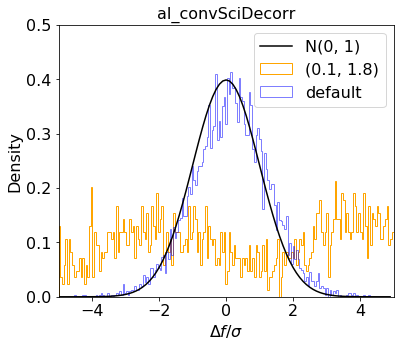

In [118]:
config = 'al_convSciDecorr'
plot_config(f'{config}', f'./paper_plots/p_{config}.pdf')

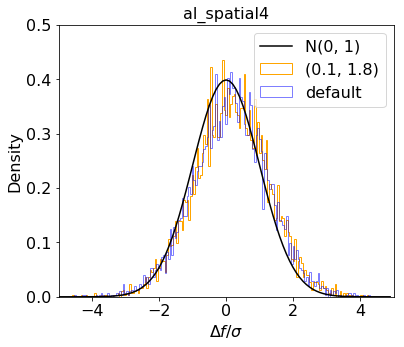

In [119]:
config = 'al_spatial4'
plot_config(f'{config}', f'./paper_plots/p_{config}.pdf')

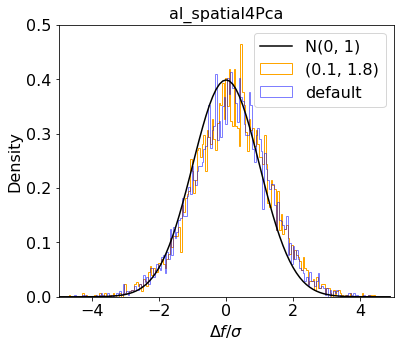

In [120]:
config = 'al_spatial4Pca'
plot_config(f'{config}', f'./paper_plots/p_{config}.pdf')

#### PSF

In [32]:
al_exp = afwImage.ExposureF('./data/patch_0to6/diff/al_default/00_20_21_1013665_79_i'
                            '/diff_20/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')
zogy_exp = afwImage.ExposureF('./data/patch_0to6/diff/zogy_55/00_20_21_1013665_79_i'
                              '/diff_20/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')

In [42]:
interval.get_limits(zogy_psf), interval.get_limits(al_psf)

((6.40293541483028e-05, 7.98167068787073e-05),
 (-1.8113509213435464e-05, 0.0005812182611678978))

Text(0.5, 1.0, 'ZOGY: Diff PSF')

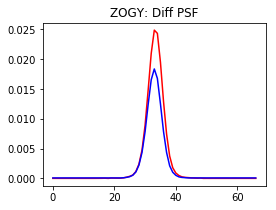

In [60]:


al_psf = al_exp.getPsf().computeImage().array
al_psf = np.pad(al_psf, pad_width=13, mode='constant', constant_values=0)

zogy_psf = zogy_exp.getPsf().computeImage().array
#al_psf = np.nansum(al_psf, axis=1)
#zogy_psf = np.nansum(zogy_psf, axis=1)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(al_psf[33], color='r')
ax.plot(zogy_psf[33], color='b')

ax.set_title('AL: Diff PSF', size=12)
ax.set_title('ZOGY: Diff PSF', size=12)
# ax.axis('off')
# plt.savefig('p_psf.pdf')

(-0.5, 66.5, -0.5, 66.5)

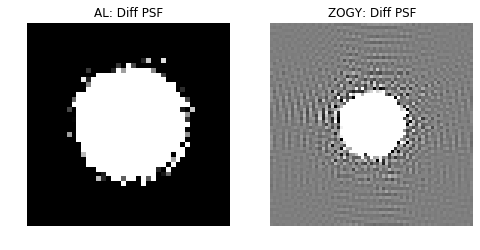

In [61]:


al_psf = al_exp.getPsf().computeImage().array
# al_psf = np.pad(al_psf, pad_width=13, mode='constant', constant_values=0)
zogy_psf = zogy_exp.getPsf().computeImage().array
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

# ax[0].imshow(al_psf,  vmin=-1.8113509213435464e-05, vmax= 0.0005812182611678978, origin='lower', cmap='gray')
ax[0].imshow(al_psf,  vmin=6.40293541483028e-05, vmax= 7.98167068787073e-05, origin='lower', cmap='gray')

# ax[1].imshow(zogy_psf[13:-13, 13:-13], vmin=6.40293541483028e-05, vmax= 7.98167068787073e-05, origin='lower', cmap='gray')
ax[1].imshow(zogy_psf, vmin=6.40293541483028e-05, vmax= 7.98167068787073e-05, origin='lower', cmap='gray')

ax[0].set_title('AL: Diff PSF', size=12)
ax[1].set_title('ZOGY: Diff PSF', size=12)
ax[0].axis('off')
ax[1].axis('off')
# plt.savefig('p_psf.pdf')

#### Host SNR

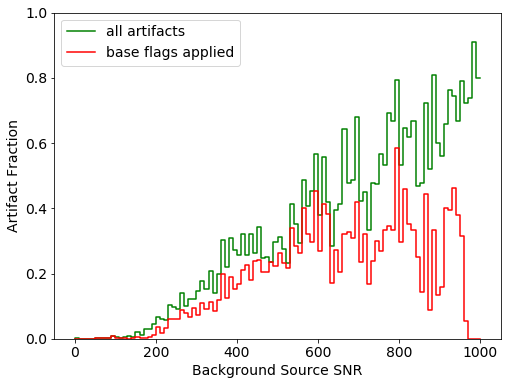

In [31]:
full_hosts = Table.read('./data/table/gal_4639/full_hosts.csv', format='ascii.csv')
base_applied = Table.read('./data/table/gal_4639/full_hosts_base_applied.csv', format='ascii.csv')
percent_list = []
for i in np.arange(-10, 1000, 10):
    low = i
    high = i + 10
    keep = np.logical_and(full_hosts['host_snr']>low, full_hosts['host_snr']<high)
    t_kept = full_hosts[keep]
    percent = np.sum(t_kept['matched_status'] == 'True') / len(t_kept)
    percent_list.append(percent)
percent_list_base_applied = []
for i in np.arange(-10, 1000, 10):
    low = i
    high = i + 10
    keep = np.logical_and(base_applied['host_snr']>low, base_applied['host_snr']<high)
    t_kept = base_applied[keep]
    percent = np.sum(t_kept['matched_status'] == 'True') / len(t_kept)
    percent_list_base_applied.append(percent)
plt.figure(figsize=(8, 6))
plt.step(np.arange(0, 1010, 10),  percent_list, color='g', label='all artifacts')
plt.step(np.arange(0, 1010, 10),  percent_list_base_applied, color='r', label='base flags applied')
plt.ylim(0, 1)
plt.ylabel('Artifact Fraction')
plt.xlabel('Background Source SNR')
plt.legend()
plt.savefig('./paper_plots/p_host_snr.pdf')

#### Host SNR, classified by FWHM

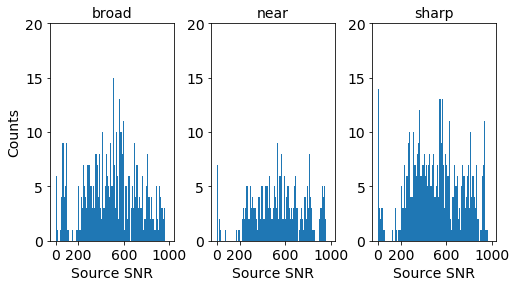

In [21]:
full_detections = Table.read('./data/table/gal_4639/full_detections.csv', format='ascii.csv')
full_detections = full_detections[full_detections['matched_status']=='True']
for flag in (base_flags):
    full_detections[flag] = (full_detections[flag].data == 'True')
full_detections['psf_ratio'] = (full_detections['calexp_fwhm'] - full_detections['coadd_fwhm']) / full_detections['coadd_fwhm']
full_detections['diaSrc_snr'] = full_detections['base_PsfFlux_instFlux'] / full_detections['base_PsfFlux_instFluxErr']
full_artifacts = full_detections[full_detections['diaSrc_snr']<60]
artifacts = dpu.remove_flag_astropy(full_artifacts, flag_list=base_flags)

broad = artifacts[artifacts['psf_ratio']>=0]
near = artifacts[np.logical_and(artifacts['psf_ratio']<0, artifacts['psf_ratio']>=-0.05)]
narrow = artifacts[artifacts['psf_ratio']<-0.05]

fig, ax = plt.subplots(1,3,figsize=(8, 4))
fig.subplots_adjust(wspace=0.3)
bins = np.arange(0, 1000, 10)
labelsize = 14
xticks = [0, 200, 600, 1000]
ylim = (0, 20)
ax[0].hist(broad['host_snr'], bins=bins)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks, fontsize=labelsize)
ax[0].set_ylim(ylim)
ax[0].set_ylabel('Counts', size=labelsize)
ax[0].set_xlabel('Source SNR', size=labelsize)
ax[0].set_title("broad", size=labelsize)
ax[1].hist(near['host_snr'], bins=bins)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticks, fontsize=labelsize)
ax[1].set_ylim(ylim)
ax[1].set_xlabel('Source SNR', size=labelsize)
ax[1].set_title("near", size=labelsize)
ax[2].hist(narrow['host_snr'], bins=bins)
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xticks, fontsize=labelsize)
ax[2].set_ylim(ylim)
ax[2].set_xlabel('Source SNR', size=labelsize)
ax[2].set_title("sharp", size=labelsize)
plt.savefig('./paper_plots/p_fwhm_host_snr.pdf')

#### Postage Stamps

In [13]:
psf_table = Table.read('./data/table/gal_4639/psf_fwhm.csv', format='ascii.csv')

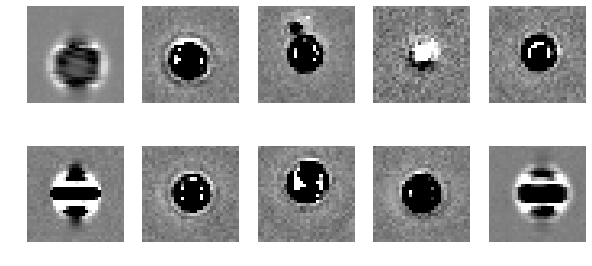

In [14]:
# saturation
display_artifacts(psf_table[2], 2, 5, figsize=(10,5), hspace=0.05)
# plt.savefig('p_sat.pdf')

1 2 5 12 13 16 21 24 26 32 33 35 36 37 38 39 40 43 49 53 57 58 59 60 62 63 64 65 66 69 

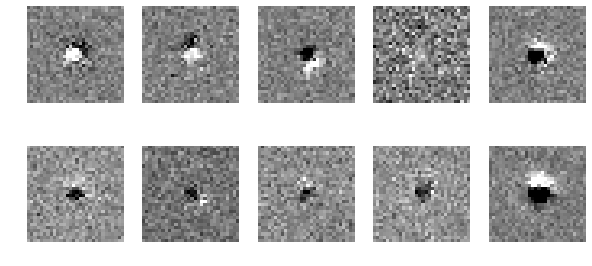

In [15]:
# broad
psf_table['fwhm_ratio'] = (psf_table['calexp_fwhm'] - psf_table['coadd_fwhm']) / psf_table['coadd_fwhm']
for i, r in enumerate(psf_table['fwhm_ratio']):
    if r >= 0:
        print(i, end=' ') 
display_artifacts(psf_table[2], 2, 5, figsize=(10,5), hspace=0.05, base_keep=False)
plt.savefig('p_broad.pdf')

0 3 6 9 14 15 22 25 29 30 41 44 46 50 51 55 

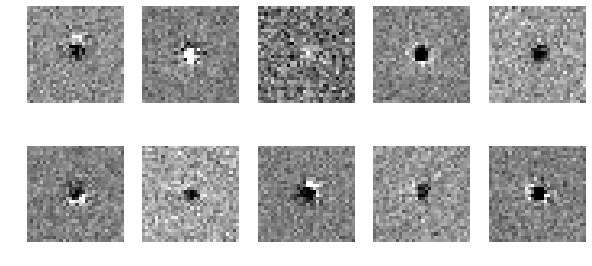

In [18]:
# near
psf_table['fwhm_ratio'] = (psf_table['calexp_fwhm'] - psf_table['coadd_fwhm']) / psf_table['coadd_fwhm']
for i, r in enumerate(psf_table['fwhm_ratio']):
    if r < 0 and r >= -0.05:
        print(i, end=' ') 
display_artifacts(psf_table[3], 2, 5, figsize=(10,5), hspace=0.05, base_keep=False)
plt.savefig('p_near.pdf')

4 7 8 10 11 17 18 19 20 23 27 28 31 34 42 45 47 48 52 54 56 61 67 68 

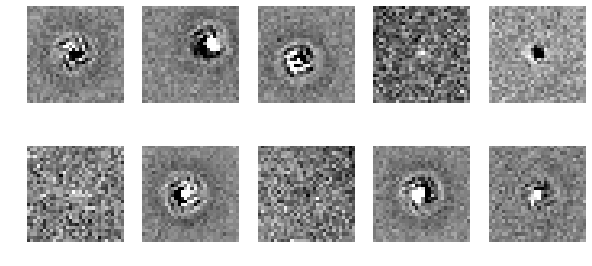

In [19]:
# sharp
psf_table['fwhm_ratio'] = (psf_table['calexp_fwhm'] - psf_table['coadd_fwhm']) / psf_table['coadd_fwhm']
for i, r in enumerate(psf_table['fwhm_ratio']):
    if r < -0.05:
        print(i, end=' ') 
display_artifacts(psf_table[4], 2, 5, figsize=(10,5), hspace=0.05, base_keep=False)
plt.savefig('p_sharp.pdf')

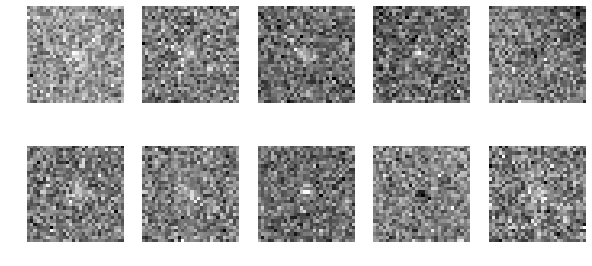

In [20]:
# faint host
full_detections = Table.read('./data/table/gal_4639/full_detections.csv', format='ascii.csv')
full_detections = full_detections[full_detections['matched_status']=='True']
full_detections['diaSrc_snr'] = full_detections['base_PsfFlux_instFlux'] / full_detections['base_PsfFlux_instFluxErr']
for flag in (base_flags):
    full_detections[flag] = (full_detections[flag].data == 'True')
full_artifacts = full_detections[full_detections['diaSrc_snr']<60]
artifacts = dpu.remove_flag_astropy(full_artifacts, flag_list=base_flags)

fig, ax = plt.subplots(2, 5, figsize=(10,5))
fig.subplots_adjust(hspace=0.05)
ax_ls = ax.flat
for i, row in enumerate(artifacts[artifacts['host_snr'] < 50]):
    visit = int(row['visit'])
    det = int(row['detector'])
    filt = str(row['filter'])
    patch1, patch2 = row['patch'][0], row['patch'][2]
    diff_path =  glob.glob(f'./data/patch_0to6/diff/al_default/{patch1}{patch2}_20_21_{visit}_{det}_{filt}/diff_20/deepDiff/*/*/diffexp*.fits')[0]
    diff_exp = afwImage.ExposureF(diff_path)
    ra = np.rad2deg(row['coord_ra'])
    dec = np.rad2deg(row['coord_dec'])
    x, y = dpu.radec2xy(ra, dec, diff_exp.getWcs())
    diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
    ax_ls[i].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
    ax_ls[i].axis('off')
    if i == 9:
        break
plt.savefig('p_faint_art.pdf')

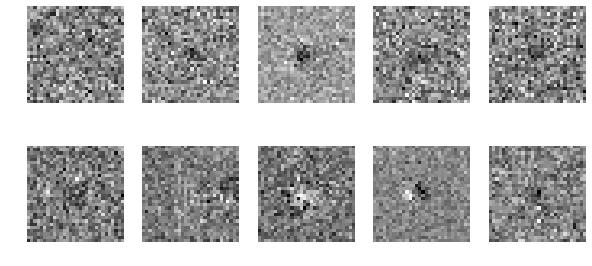

In [21]:
# unmatched
full_detections = Table.read('./data/table/gal_4639/full_detections.csv', format='ascii.csv')
full_detections['diaSrc_snr'] = full_detections['base_PsfFlux_instFlux'] / full_detections['base_PsfFlux_instFluxErr']
for flag in (base_flags):
    full_detections[flag] = (full_detections[flag].data == 'True')
full_artifacts = full_detections[full_detections['diaSrc_snr']<60]
artifacts = dpu.remove_flag_astropy(full_artifacts, flag_list=base_flags)

fig, ax = plt.subplots(2, 5, figsize=(10,5))
fig.subplots_adjust(hspace=0.05)
ax_ls = ax.flat
for i, row in enumerate(artifacts[artifacts['matched_status']=='False'][11:]):
    visit = int(row['visit'])
    det = int(row['detector'])
    filt = str(row['filter'])
    patch1, patch2 = row['patch'][0], row['patch'][2]
    diff_path =  glob.glob(f'./data/patch_0to6/diff/al_default/{patch1}{patch2}_20_21_{visit}_{det}_{filt}/diff_20/deepDiff/*/*/diffexp*.fits')[0]
    diff_exp = afwImage.ExposureF(diff_path)
    ra = np.rad2deg(row['coord_ra'])
    dec = np.rad2deg(row['coord_dec'])
    x, y = dpu.radec2xy(ra, dec, diff_exp.getWcs())
    diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
    ax_ls[i].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
    ax_ls[i].axis('off')
    if i == 9:
        break
plt.savefig('p_unmatched.pdf')

#### Dipole in AL and ZOGY

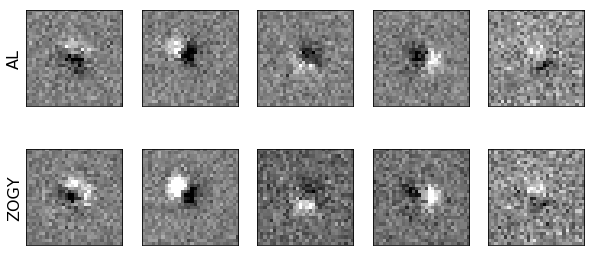

In [17]:
al_diff = afwImage.ExposureF('./data/patch_0to6/diff/al_default/00_20_21_1013665_79_i/diff_20/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')
zogy_diff = afwImage.ExposureF('./data/patch_0to6/diff/zogy_55/00_20_21_1013665_79_i/diff_20/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')

base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter',
             'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_suspectCenter',
             'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge','base_PixelFlags_flag_bad']
diff_diaSrc = BaseCatalog.readFits('./data/patch_0to6/diff/al_default/00_20_21_1013665_79_i/diff_20/deepDiff/v01013665-fi/R20/diaSrc_01013665-i-R20-S21-det079.fits')
diff_diaSrc_astropy = diff_diaSrc.asAstropy()
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
diaSrc_base_rm = dpu.remove_flag_astropy(diff_diaSrc_astropy, flag_list=base_flags)
diaSrc_dipole_keep = dpu.keep_flag_astropy(diaSrc_base_rm, flag_list=dipole_flags)

fig, ax = plt.subplots(2, 5, figsize=(10,5))
fig.subplots_adjust(hspace=0.05)
for i, row in enumerate(diaSrc_dipole_keep[1:]):
    if i ==5:
        break
    x = row['base_NaiveCentroid_x']
    y = row['base_NaiveCentroid_y']
    al_stamp = dpu.make_cutout(al_diff, x, y, cutout_size=30)
    zogy_stamp = dpu.make_cutout(zogy_diff, x, y, cutout_size=30)
    ax[0][i].imshow(interval(al_stamp.getImage().array), cmap='gray', origin='lower')
    ax[1][i].imshow(interval(zogy_stamp.getImage().array), cmap='gray', origin='lower')
    ax[0][i].set_xticks([])
    ax[1][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[1][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('AL', size=16)
        ax[1][i].set_ylabel('ZOGY', size=16)
plt.savefig('./paper_plots/p_al_zogy.pdf')


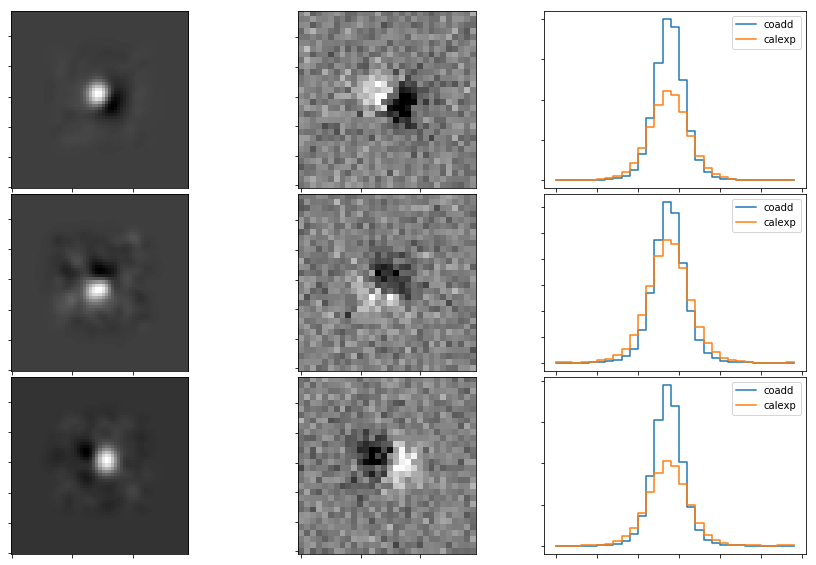

In [22]:

calexp_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1'
calexp_butler = Butler(calexp_repo)
# get exp and photocalib
calexp_id = {'visit': 1013665, 'detector': 79, 'filter': 'i'}
calexp_exp = calexp_butler.get('calexp', calexp_id)
calexp_calib = calexp_butler.get(datasetType='calexp_photoCalib', dataId=calexp_id)

coadd_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
coadd_butler = Butler(coadd_repo)
# get expo and photocalib
coadd_id = {'tract': 4639, 'patch': '0,0', 'filter': 'i'}
coadd_exp = coadd_butler.get('deepCoadd', coadd_id)
coadd_calib = coadd_butler.get(datasetType='deepCoadd_calexp_photoCalib', dataId=coadd_id)
coadd_scaling = coadd_calib.instFluxToNanojansky(1), 
calexp_scaling = calexp_calib.instFluxToNanojansky(1)
coadd_psf = coadd_exp.getPsf()
calexp_psf = calexp_exp.getPsf()

diff_exp = afwImage.ExposureF('./data/patch_0to6/diff/al_default/00_20_21_1013665_79_i/diff_20/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')

coadd_warped = dpu.warp_to_exposure(coadd_exp, calexp_exp)
diff_warped = dpu.warp_to_exposure(diff_exp, calexp_exp)

base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter',
             'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_suspectCenter',
             'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge','base_PixelFlags_flag_bad']
diff_diaSrc = BaseCatalog.readFits('./data/patch_0to6/diff/al_default/00_20_21_1013665_79_i/diff_20/deepDiff/v01013665-fi/R20/diaSrc_01013665-i-R20-S21-det079.fits')
diff_diaSrc_astropy = diff_diaSrc.asAstropy()
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
diaSrc_base_rm = dpu.remove_flag_astropy(diff_diaSrc_astropy, flag_list=base_flags)
diaSrc_dipole_keep = dpu.keep_flag_astropy(diaSrc_base_rm, flag_list=dipole_flags)
fig, ax = plt.subplots(3, 3, figsize=(15,10))
ax_ls = ax.flat
fig.subplots_adjust(hspace=0.03, wspace=0.1)
for i, row in enumerate(diaSrc_dipole_keep[2:]):
    if i ==3:
        break
    ra = np.rad2deg(row['coord_ra'])
    dec = np.rad2deg(row['coord_dec'])
    
    calexp_x, calexp_y = dpu.radec2xy(ra, dec, calexp_exp.getWcs())
    coadd_x, coadd_y = dpu.radec2xy(ra, dec, coadd_warped.getWcs())
    diff_x, diff_y = dpu.radec2xy(ra, dec, diff_warped.getWcs())
    
    calexp_xy = geom.Point2D(calexp_x, calexp_y)
    coadd_xy = geom.Point2D(coadd_x, coadd_y)

    calexp_stamp = dpu.make_cutout(calexp_exp, calexp_x, calexp_y, cutout_size=30)
    coadd_stamp = dpu.make_cutout(coadd_warped, coadd_x, coadd_y, cutout_size=30)
    diff_stamp = dpu.make_cutout(diff_warped, diff_x, diff_y, cutout_size=30)
    
    calexp_stamp_psf = calexp_psf.computeImage(calexp_xy).array
    calexp_stamp_psf = np.pad(calexp_stamp_psf, pad_width=9, mode='constant', constant_values=0)
    coadd_stamp_psf = coadd_psf.computeImage(coadd_xy).array
    d, k1, k2 = cross_cov(coadd_stamp.getImage().array, calexp_stamp.getImage().array,
                          coadd_scaling, calexp_scaling, coadd_stamp_psf, calexp_stamp_psf)
    ax[i][0].imshow(d, origin='lower', cmap='gray')
    ax[i][1].imshow(interval(diff_stamp.getImage().array), origin='lower', cmap='gray')
    ax[i][2].step(x=np.arange(30),y=coadd_stamp.getImage().array[15,:]*coadd_scaling, label='coadd')
    ax[i][2].step(x=np.arange(30),y=calexp_stamp.getImage().array[15,:]*calexp_scaling, label='calexp')
    ax[i][2].set
    ax[i][2].legend()
plt.setp(ax[:, :], xticklabels=[], yticklabels=[]);

plt.savefig('p_sampling.pdf')
